In [1]:
from keras.layers import Lambda, Input, Dense, Reshape, Dropout, Conv2D, Flatten
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model

from keras.metrics import categorical_crossentropy

import tensorflow as tf
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, mean_squared_error

import pandas as pd
import numpy as np
import xarray as xr

from scipy import stats
#import xesmf as xe
from math import ceil

import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import seaborn as sns

import clustering_functions as cf
import skill_functions as sf
import preprocessing_functions as pf

In [2]:
g0 = 9.80665
extended_winter_months = [11, 12, 1, 2, 3]

#### Parameters

In [3]:
import yaml
from yaml import CLoader as Loader

# CHANGE
cluster_number = 5
reconstruction_loss_factor = 0.5
filepath = "results/cmmvae/"

pr_cluster_number = 5

original_dim = 825
inputdim1 = 25
inputdim2 = 33

latent_dim = 15

activation_function = 'relu'

dim_layer1 = 256
dim_layer2 = 128
dim_layer3 = 64

cat_dim = 1

batch_size = 128
epochs = 150

input_shape = (original_dim, )
input_shape_r = (pr_cluster_number, )

In [4]:
# sampling function

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1]), mean=0., stddev=1.)
    return z_mean + K.exp(0.5*z_log_sigma) * epsilon

### Data pre-processing

In [5]:
z500 = pf.preprocess_dataset(filename = '../data.nosync/era5_z500_daily_250_atlantic_1940_2022.nc',
                              variable_name = 'z', 
                              multiplication_factor = 1/g0, 
                              geographical_filter = 'new atlantic', 
                              months_filter = extended_winter_months, 
                              anomalies = True, 
                              normalization = False,
                              rolling_window = 5)

z500 = z500.where(z500['time.year'] > 1980, drop=True)
z500 = z500.where(z500['time.year'] < 2023, drop=True)


weights = np.cos(np.deg2rad(z500.latitude))
z500 = z500*weights
z500 = z500/z500.std()

z500_reshaped = cf.reshape_data_for_clustering(z500)

In [6]:
# CHIRPS

pr_labels = pd.read_csv('../data.nosync/CHIRPS_pr_cluster_labels_5.csv')
pr_labels.columns = ['index', 'labels']
#by souma pr_labels.drop(pr_labels.tail(1).index,inplace=True)

pr_labels['values']=[1]*len(pr_labels)
label_indices_pd = pd.pivot_table(pr_labels, values='values', index=['index'],
                    columns=['labels'], aggfunc=np.sum).fillna(0)
label_indices = label_indices_pd.values

threshold_qn95 = xr.open_dataset('../data.nosync/CHIRPS_pr_95pc_EW.nc')
threshold_qn95 = threshold_qn95.where(threshold_qn95['time.year'] < 2023, drop=True)['precipitation_amount']

pr_spatial = xr.open_dataset('../data.nosync/CHIRPS_pr_total_EW.nc')['precipitation_amount']
pr_spatial = pr_spatial.where(pr_spatial['time.year'] < 2023, drop=True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25776\355016934.py:8: FutureWarning: The provided callable <function sum at 0x00000280DC67AA70> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  label_indices_pd = pd.pivot_table(pr_labels, values='values', index=['index'],


## Define model

**Encoder**

In [7]:
inputs_x = Input(shape=input_shape, name='encoder_input')
inputs_r = Input(shape=input_shape_r, name='ground_truth')

inter_x1 = Dense(dim_layer1, activation=activation_function, name='encoder_intermediate')(inputs_x)
inter_x2 = Dense(dim_layer2, activation=activation_function, name='encoder_intermediate_2')(inter_x1)
inter_x3 = Dense(dim_layer3, activation=activation_function, name='encoder_intermediate_3')(inter_x2)

dummy = Input(shape=(1,), name='dummy')
mu_vector = Dense(cluster_number*latent_dim, name='mu_vector',use_bias=False)(dummy)
mu = Reshape((cluster_number,latent_dim), name='mu')(mu_vector)

pi = Dense(cluster_number, activation='softmax', name='pi')(dummy)
c = Dense(cluster_number, activation='softmax', name='c')(inter_x3)

z_mean = Dense(latent_dim, name='z_mean')(inter_x3)
z_log_var = Dense(latent_dim, name='z_log_var')(inter_x3)

r = Dense(pr_cluster_number, name='r_label', activation='softmax')(inter_x3)

cr = Dense(cluster_number, activation='softmax', name='cr')(r)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model([inputs_x,dummy, inputs_r], [z_mean, z_log_var, z, mu, c, pi, r, cr], name='encoder')

encoder.summary()
plot_model(encoder, show_shapes=True, dpi=100)
plot_model(encoder, to_file=filepath+'encoder_graph.png', show_shapes=True, dpi=100)


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 825)]                0         []                            
                                                                                                  
 encoder_intermediate (Dens  (None, 256)                  211456    ['encoder_input[0][0]']       
 e)                                                                                               
                                                                                                  
 encoder_intermediate_2 (De  (None, 128)                  32896     ['encoder_intermediate[0][0]']
 nse)                                                                                             
                                                                                           

**Decoder**

In [8]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

inter_y1 = Dense(dim_layer3, activation=activation_function)(latent_inputs)
inter_y2 = Dense(dim_layer2, activation=activation_function)(inter_y1)
inter_y3 = Dense(dim_layer1, activation=activation_function)(inter_y2)

outputs = Dense(original_dim)(inter_y3)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, show_shapes=True, dpi=100)
plot_model(decoder, to_file=filepath+'decoder_graph.png', show_shapes=True, dpi=100)

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 15)]              0         
                                                                 
 dense (Dense)               (None, 64)                1024      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 825)               212025    
                                                                 
Total params: 254393 (993.72 KB)
Trainable params: 254393 (993.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
You must install py

**combine encoder and decoder to VAE model and print summary**

In [9]:
outputs = decoder(encoder([inputs_x, dummy, inputs_r])[2])

vae = Model([inputs_x,dummy, inputs_r], outputs, name='vae_classification')

vae.summary()

Model: "vae_classification"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 825)]                0         []                            
                                                                                                  
 dummy (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 ground_truth (InputLayer)   [(None, 5)]                  0         []                            
                                                                                                  
 encoder (Functional)        [(None, 15),                 255323    ['encoder_input[0][0]',       
                              (None, 15),                            'dummy[0][0]

### Loss function

In [10]:
reconstruction_loss = mse(inputs_x, outputs)*original_dim*reconstruction_loss_factor

prediction_loss = categorical_crossentropy(c, cr)

target_loss = (categorical_crossentropy(inputs_r, r) + categorical_crossentropy(r, r))*pr_cluster_number

kl_loss_all = tf.compat.v1.get_variable("kl_loss_all", [batch_size,1], 
                                dtype=tf.float32,initializer=tf.zeros_initializer)

kl_cat_all = tf.compat.v1.get_variable("kl_cat_all", [batch_size,1], 
                                dtype=tf.float32,initializer=tf.zeros_initializer)
dir_prior_all = tf.compat.v1.get_variable("dir_prior_all", [batch_size,1], 
                                  dtype=tf.float32,initializer=tf.zeros_initializer)

for i in range(0,cluster_number):
    
    kl_loss = 1 + z_log_var - tf.math.square(z_mean-mu[:,i,:]) - tf.math.exp(z_log_var)
    kl_loss = tf.multiply(tf.reduce_sum(kl_loss, axis=-1), c[:,i])
    kl_loss = -0.5*(kl_loss)
    kl_loss_all = kl_loss_all + kl_loss
    
    mc = tf.reduce_mean(c[:,i])
    mpi = tf.reduce_mean(pi[:,i])
    kl_cat = mc * tf.math.log(mc)- mc * tf.math.log(mpi)
    kl_cat_all = kl_cat_all+kl_cat
    
    dir_prior = -tf.math.log(pi[:,i])*0.5
    dir_prior_all = dir_prior_all + dir_prior

**Set loss function for model**

In [11]:
vae_loss = K.mean(reconstruction_loss+prediction_loss+target_loss+kl_loss_all+kl_cat_all+dir_prior_all)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

vae.save_weights(filepath+'random_weights_'+str(cluster_number)+'.h5')


Model: "vae_classification"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 825)]                0         []                            
                                                                                                  
 dummy (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 ground_truth (InputLayer)   [(None, 5)]                  0         []                            
                                                                                                  
 encoder (Functional)        [(None, 15),                 255323    ['encoder_input[0][0]',       
                              (None, 15),                            'dummy[0][0

## Train model 

In [12]:
X = cf.reshape_data_for_clustering(z500)
y = label_indices
dummy_full = np.ones((X.shape[0],1))

**Test convergence of loss function**

Epoch 1/150
35/35 [==============================] - 3s 17ms/step - loss: 356.0634 - val_loss: 225.7628
Epoch 2/150
35/35 [==============================] - 0s 5ms/step - loss: 197.6771 - val_loss: 173.5688
Epoch 3/150
35/35 [==============================] - 0s 5ms/step - loss: 157.3293 - val_loss: 144.5554
Epoch 4/150
35/35 [==============================] - 0s 5ms/step - loss: 131.3036 - val_loss: 122.1567
Epoch 5/150
35/35 [==============================] - 0s 5ms/step - loss: 116.5022 - val_loss: 112.4491
Epoch 6/150
35/35 [==============================] - 0s 5ms/step - loss: 108.1676 - val_loss: 103.8273
Epoch 7/150
35/35 [==============================] - 0s 5ms/step - loss: 96.9374 - val_loss: 92.1631
Epoch 8/150
35/35 [==============================] - 0s 5ms/step - loss: 88.6327 - val_loss: 86.7481
Epoch 9/150
35/35 [==============================] - 0s 5ms/step - loss: 84.1224 - val_loss: 83.1344
Epoch 10/150
35/35 [==============================] - 0s 6ms/step - loss: 80.4

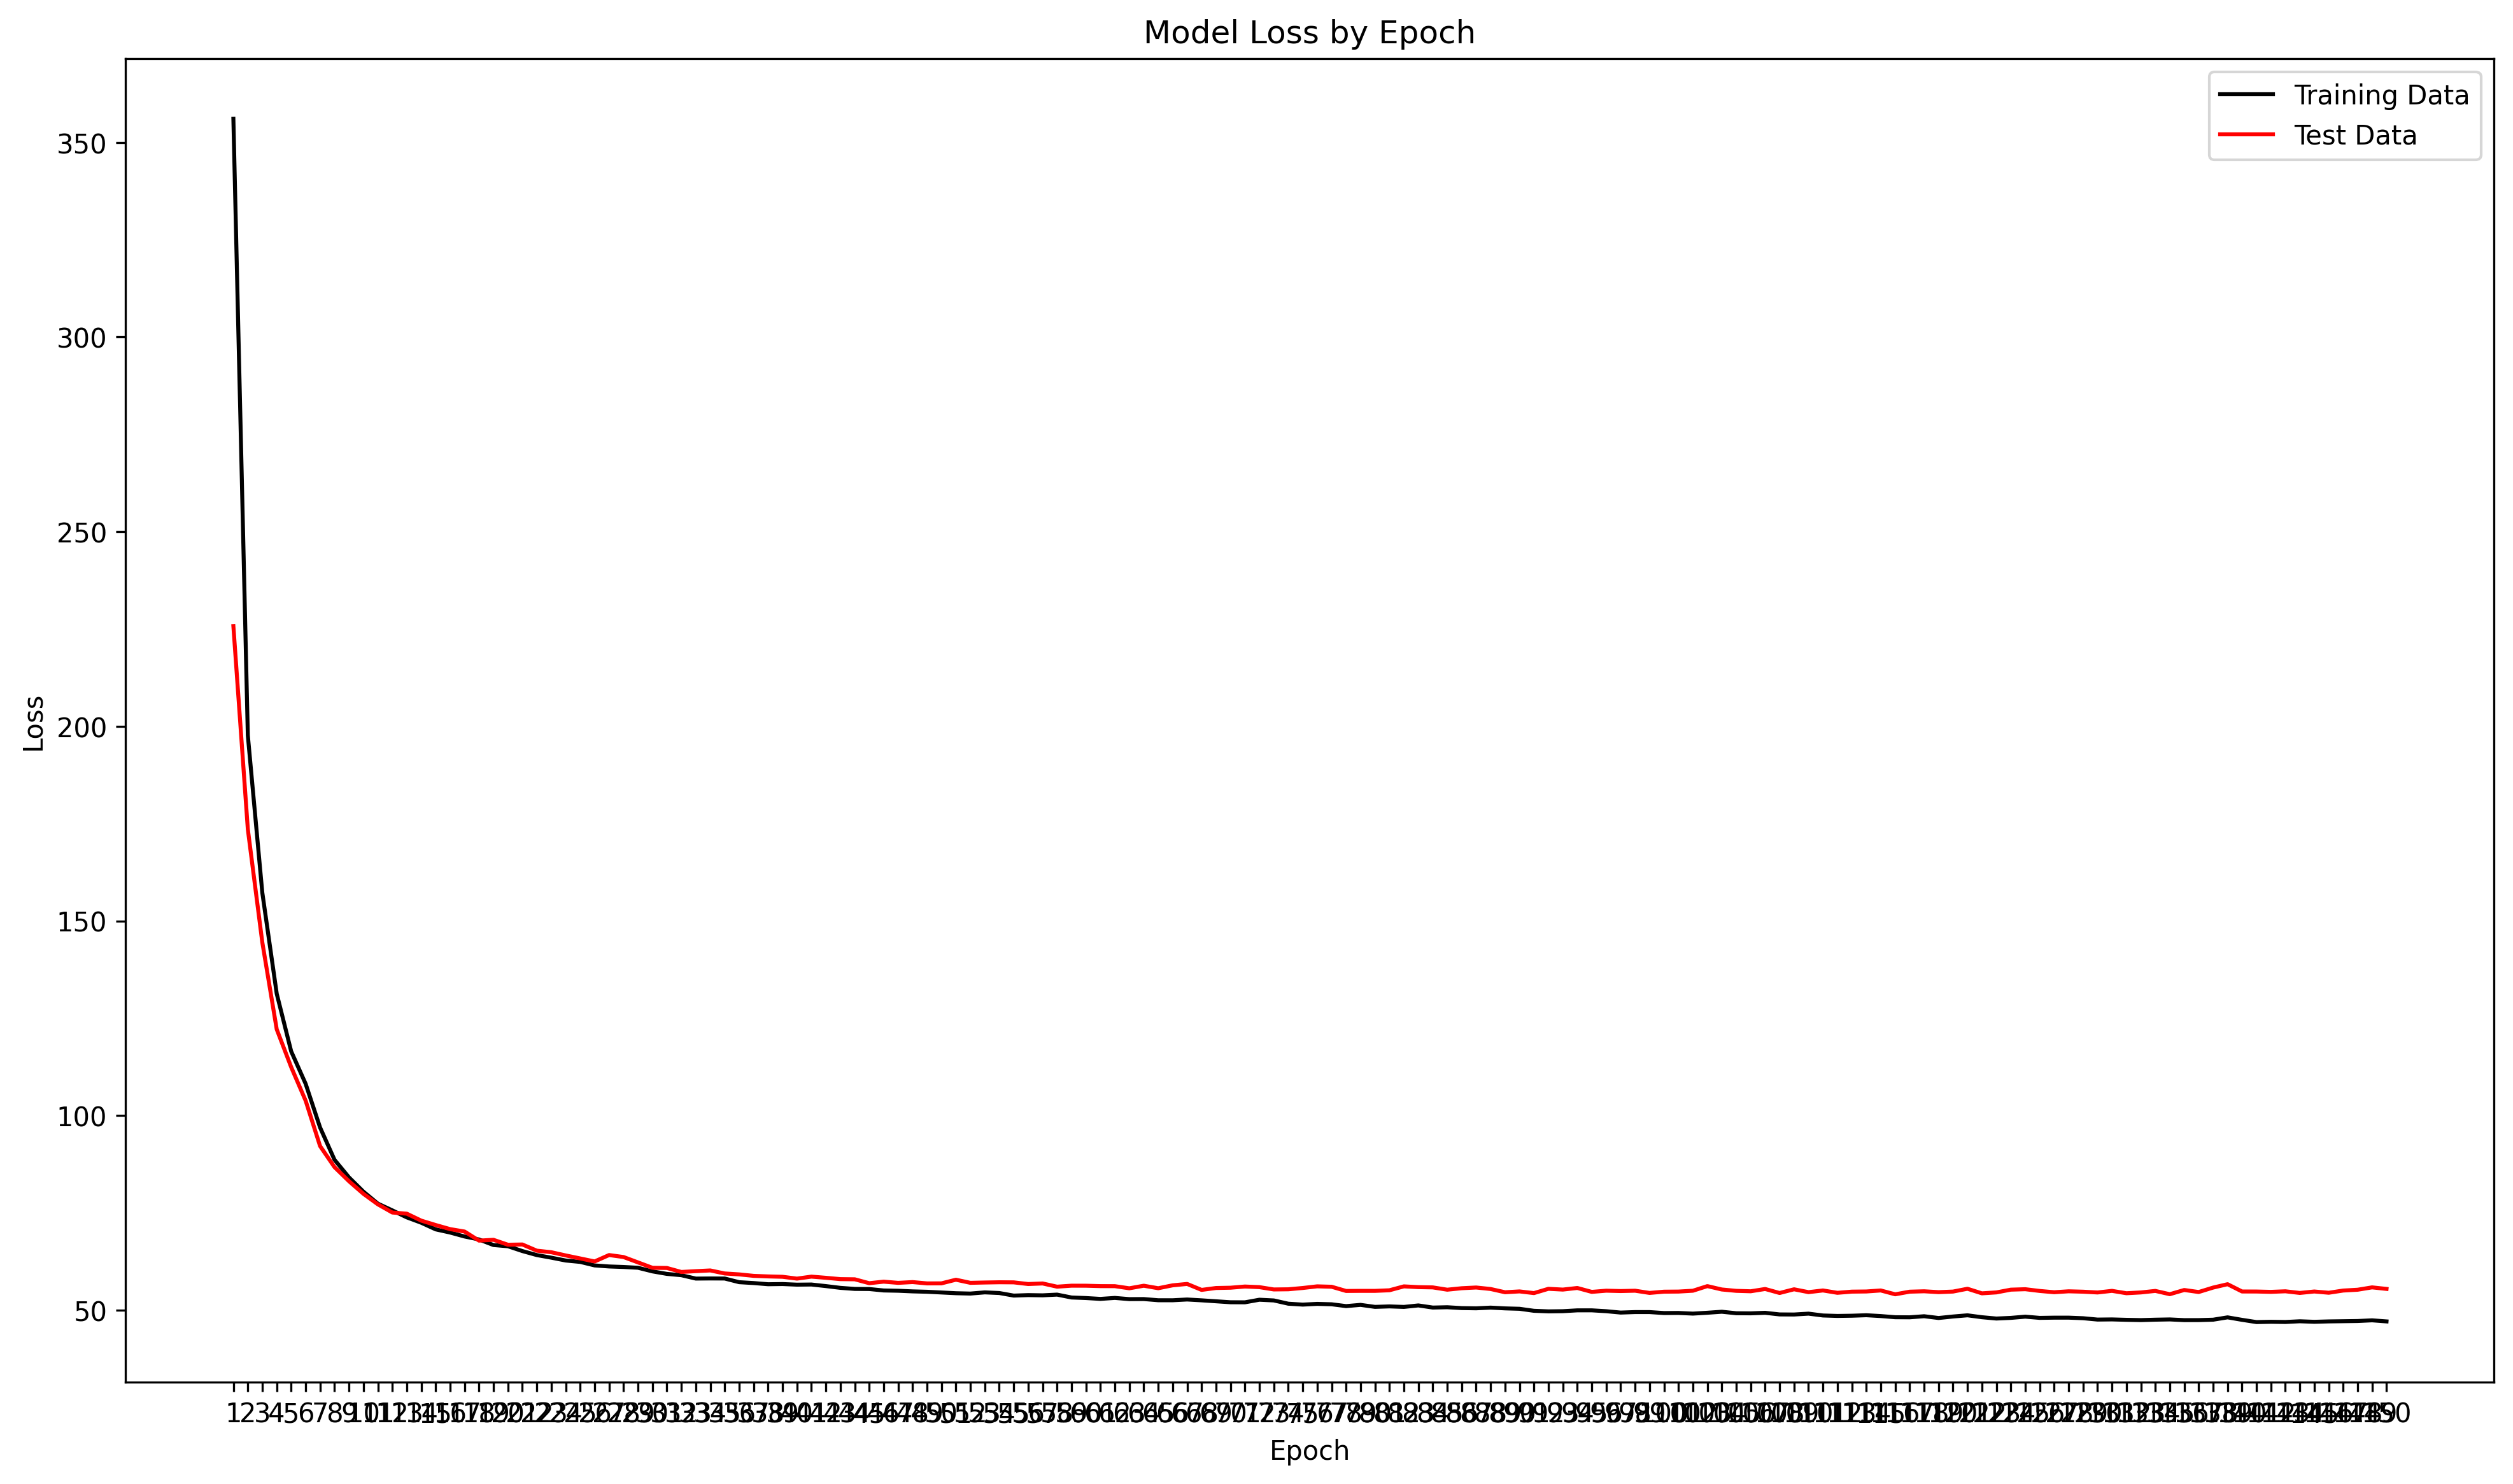

In [13]:
X_train_1, X_test_1, y_train, y_test = train_test_split(z500.values, y, test_size=0.3)

nt,ny,nx = X_train_1.shape
X_train = np.reshape(X_train_1, [nt, ny*nx], order='F')

nt,ny,nx = X_test_1.shape
X_test = np.reshape(X_test_1, [nt, ny*nx], order='F')

dummy_train = np.ones((X_train.shape[0],1))
dummy_test = np.ones((X_test.shape[0],1))

vae.load_weights(filepath+'random_weights_'+str(cluster_number)+'.h5')

history = vae.fit([X_train, dummy_train, y_train], [X_train, dummy_train, y_train], epochs=epochs, 
                  batch_size=batch_size, 
                  validation_data=([X_test,dummy_test,y_test], [X_test,dummy_test,y_test]))
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1))
plt.legend()
plt.show()

#### Cross-validation of model

In [14]:
for count in range(20):
    
    X_train_1, X_test_1, y_train, y_test = train_test_split(z500.values, y, test_size=0.3)

    nt,ny,nx = X_train_1.shape
    X_train = np.reshape(X_train_1, [nt, ny*nx], order='F')

    nt,ny,nx = X_test_1.shape
    X_test = np.reshape(X_test_1, [nt, ny*nx], order='F')

    dummy_train = np.ones((X_train.shape[0],1))
    dummy_test = np.ones((X_test.shape[0],1))

    vae.load_weights(filepath+'random_weights_'+str(cluster_number)+'.h5')

    history = vae.fit([X_train, dummy_train, y_train], [X_train, dummy_train, y_train], epochs=epochs, 
                      batch_size=batch_size, 
                      validation_data=([X_test,dummy_test,y_test], [X_test,dummy_test,y_test]))
    
    vae.save_weights(filepath+'final_weights_'+str(cluster_number)+'_'+str(count)+'.h5')

Epoch 1/150
35/35 [==============================] - 0s 6ms/step - loss: 372.1978 - val_loss: 242.3813
Epoch 2/150
35/35 [==============================] - 0s 5ms/step - loss: 200.8672 - val_loss: 168.2838
Epoch 3/150
35/35 [==============================] - 0s 5ms/step - loss: 147.8731 - val_loss: 133.3599
Epoch 4/150
35/35 [==============================] - 0s 5ms/step - loss: 130.0563 - val_loss: 128.3159
Epoch 5/150
35/35 [==============================] - 0s 5ms/step - loss: 124.6539 - val_loss: 123.3615
Epoch 6/150
35/35 [==============================] - 0s 5ms/step - loss: 115.4257 - val_loss: 111.5400
Epoch 7/150
35/35 [==============================] - 0s 6ms/step - loss: 106.1697 - val_loss: 101.5354
Epoch 8/150
35/35 [==============================] - 0s 5ms/step - loss: 95.5317 - val_loss: 92.4563
Epoch 9/150
35/35 [==============================] - 0s 6ms/step - loss: 89.9720 - val_loss: 89.6936
Epoch 10/150
35/35 [==============================] - 0s 6ms/step - loss: 86.

**Load chosen weights and test on entire dataset**

In [15]:
# After your cross-validation loop (after line 138), add this:

# Find the best model from the 20 runs
best_val_losses = []
for count in range(20):
    vae.load_weights(filepath+'final_weights_'+str(cluster_number)+'_'+str(count)+'.h5')
    
    # Evaluate on the full dataset
    [z_mean_enc, z_log_var_enc, z_enc, mu_enc, c_enc, pi_enc, r_enc, cr_enc] = encoder.predict([X, dummy_full, y], batch_size=batch_size)
    X_decoded = decoder.predict(z_enc, batch_size=batch_size)
    
    # Calculate reconstruction error on full dataset
    reconstruction_loss = np.mean(np.square(X - X_decoded))
    best_val_losses.append((count, reconstruction_loss))
    print(f"Model {count}: Reconstruction Loss = {reconstruction_loss:.4f}")

# Select the model with lowest reconstruction loss
best_val_losses.sort(key=lambda x: x[1])
chosen_count = best_val_losses[0][0]
print(f"\n**BEST MODEL: Iteration {chosen_count} with loss {best_val_losses[0][1]:.4f}**\n")

50/50 [==============================] - 0s 890us/step
Model 0: Reconstruction Loss = 0.0455
50/50 [==============================] - 0s 883us/step
Model 1: Reconstruction Loss = 0.0446
50/50 [==============================] - 0s 942us/step
Model 2: Reconstruction Loss = 0.0472
50/50 [==============================] - 0s 950us/step
Model 3: Reconstruction Loss = 0.0476
50/50 [==============================] - 0s 1ms/step
Model 4: Reconstruction Loss = 0.0477
50/50 [==============================] - 0s 941us/step
Model 5: Reconstruction Loss = 0.0451
50/50 [==============================] - 0s 974us/step
Model 6: Reconstruction Loss = 0.0453
50/50 [==============================] - 0s 969us/step
Model 7: Reconstruction Loss = 0.0463
50/50 [==============================] - 0s 931us/step
Model 8: Reconstruction Loss = 0.0455
50/50 [==============================] - 0s 944us/step
Model 9: Reconstruction Loss = 0.0445
50/50 [==============================] - 0s 988us/step
Model 10: Reconst

In [39]:
chosen_count = 12
vae.load_weights(filepath+'final_weights_'+str(cluster_number)+'_'+str(chosen_count)+'.h5')

[z_mean_enc, z_log_var_enc, z_enc, mu_enc, c_enc, pi_enc, r_enc, cr_enc] = encoder.predict([X,dummy_full, y],batch_size=batch_size)

50/50 [==============================] - 0s 2ms/step


## Evaluation

### Reconstruction loss and samples

In [40]:
X_decoded = decoder.predict(z_enc)

reconstructed = X_decoded.reshape(X_decoded.shape[0], inputdim2, inputdim1)
reconstructed = np.transpose(reconstructed, (0, 2, 1))
reconstructed_xr = xr.DataArray(reconstructed, coords=z500[0:X_decoded.shape[0], :, :].coords, 
                         dims=z500[0:X_decoded.shape[0], :, :].dims, attrs=z500[0:X_decoded.shape[0], :, :].attrs)

mse_reconstruction = mean_squared_error(X_decoded, X, multioutput='raw_values')
d = {'MSE': 'VAE_CMM', 'k': cluster_number, 'Value': mse_reconstruction}
df = pd.DataFrame(data=d)

199/199 [==============================] - 0s 921us/step


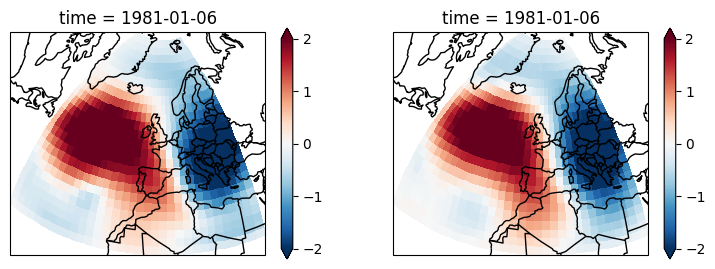

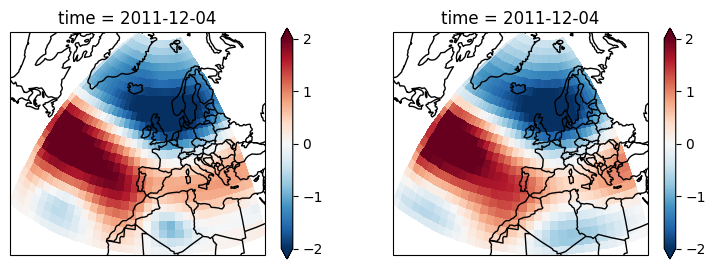

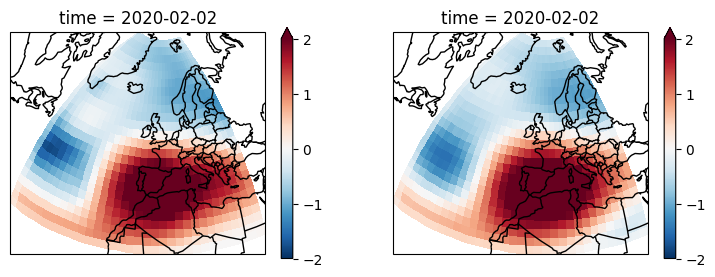

In [41]:
for i in [5, 4660, 5930]:

    fig = plt.figure(figsize=[14,3])

    ax1 = fig.add_subplot(131, projection=ccrs.Orthographic(0,45))
    z500[i, :, :].plot(ax=ax1, cmap='RdBu_r', transform=ccrs.PlateCarree(), vmin=-2, vmax=2)
    ax1.coastlines()
    ax1.add_feature(cartopy.feature.BORDERS)

    ax2 = fig.add_subplot(132, projection = ccrs.Orthographic(0,45))
    reconstructed_xr[i, :, :].plot(ax=ax2, cmap='RdBu_r', transform=ccrs.PlateCarree(), vmin=-2, vmax=2)
    ax2.coastlines()
    ax2.add_feature(cartopy.feature.BORDERS)

## Skill score

In [42]:
final_labels = np.zeros(X.shape[0])
for i in range(0, X.shape[0]):
    max_prob = np.max(c_enc[i,:])
    idx = np.argmax(c_enc[i,:])
    final_labels[i] = idx

In [43]:
# get maximum likelihood labels

df = pd.DataFrame(data=c_enc)
df['label'] = final_labels
#df.to_csv(filepath+'cluster_probabilities_'+str(cluster_number)+'.csv')

print('calculating skill score')

bss_95 = sf.calculate_95pc_skill_score_probabilistic(cluster_number_z500 = cluster_number, 
                                                  z500_cluster_probabilities = c_enc, 
                                                  pr_spatial = pr_spatial)

print(bss_95)

bss_cluster = sf.calculate_cluster_skill_score_probabilistic(cluster_number_pr = 5, 
                                                             cluster_number_z500 = cluster_number, 
                                                             pr_cluster_labels = np.array(pr_labels['labels']),
                                                             z500_cluster_probabilities = c_enc)

print(bss_cluster)

bss_tercile = sf.calculate_tercile_skill_score_probabilistic(cluster_number_z500 = cluster_number, 
                                                  z500_cluster_probabilities = c_enc, 
                                                  pr_spatial = pr_spatial)

print(bss_tercile)

# FIRST ROUND
#df = pd.DataFrame(data={'k': [cluster_number], 'bss_cluster': [bss_cluster], 'bss_95': [bss_95], 'bss_tercile': [bss_tercile]})
#df.to_csv(filepath+'skill_score.csv', index=False)

# OTHER ROUND
#df_prior = pd.read_csv(filepath+'skill_score.csv')
#df = pd.DataFrame(data={'k': [cluster_number], 'bss_cluster': [bss_cluster], 'bss_95': [bss_95], 'bss_tercile': [bss_tercile]})
#df_new = df_prior.append(df)
#df_new.to_csv(filepath+'skill_score.csv', index=False)

calculating skill score
Aggregating 3D precipitation data to 1D area-mean for 95pc skill score...
0.09902421761010505
0.12771476072936705
<xarray.DataArray (latitude: 166, longitude: 244)> Size: 324kB
array([[      -inf, 0.02501366, 0.0278338 , ...,       -inf,       -inf,
              -inf],
       [      -inf,       -inf,       -inf, ...,       -inf,       -inf,
              -inf],
       [      -inf,       -inf,       -inf, ...,       -inf,       -inf,
              -inf],
       ...,
       [      -inf,       -inf,       -inf, ...,       -inf,       -inf,
              -inf],
       [      -inf,       -inf,       -inf, ...,       -inf,       -inf,
              -inf],
       [      -inf,       -inf,       -inf, ...,       -inf,       -inf,
              -inf]])
Coordinates:
  * latitude   (latitude) float64 1kB 27.67 27.72 27.77 ... 35.82 35.87 35.92
  * longitude  (longitude) float64 2kB -13.17 -13.12 -13.07 ... -1.075 -1.025


### Cluster centers

In [44]:
"""# re-order labels

precip_sum = pd.DataFrame(pr_spatial.values[:6352]).groupby(final_labels).sum().reset_index()
precip_sum['index']=precip_sum['index'].astype('int')
precip_sum = precip_sum.rename(columns={"index": "index_old"})
precip_sum = precip_sum.sort_values(by=0, ascending=False)
precip_sum['index_new'] = np.arange(precip_sum.shape[0])

labels_reordered = final_labels.copy()

for i in range(len(final_labels)):
    
    new_label = precip_sum[precip_sum['index_old']==final_labels[i].astype('int')]['index_new'].values[0]
    
    labels_reordered[i] = new_label
    
precip_sum['index_old'].values.tolist()""" 
# re-order labels

# FIX: Sum over latitude and longitude first to get total daily precipitation (1D array)
pr_total_daily = pr_spatial.sum(dim=['latitude', 'longitude']).values[:6352]

# Now create DataFrame with the 1D total precipitation
precip_sum = pd.DataFrame(pr_total_daily, columns=['values'])
precip_sum['label'] = final_labels
precip_sum = precip_sum.groupby('label').sum().reset_index()

precip_sum = precip_sum.rename(columns={"label": "index_old"})
precip_sum = precip_sum.sort_values(by='values', ascending=False)
precip_sum['index_new'] = np.arange(precip_sum.shape[0])

labels_reordered = final_labels.copy()

for i in range(len(final_labels)):
    
    # Match old label to new index
    new_label = precip_sum[precip_sum['index_old']==final_labels[i].astype('int')]['index_new'].values[0]
    
    labels_reordered[i] = new_label

print(precip_sum)

   index_old      values  index_new
3        3.0  49262696.0          0
4        4.0  25807080.0          1
0        0.0  23373048.0          2
2        2.0  14962891.0          3
1        1.0  13802485.0          4


In [45]:



# save re-ordered cluster labels and probabilities

df = pd.DataFrame(data=c_enc)
df_reordered = df[precip_sum['index_old'].values.tolist()]
df_reordered.columns= [*range(cluster_number)]
df_reordered['label'] = labels_reordered

#df_reordered.to_csv(filepath+'cluster_probabilities_'+str(cluster_number)+'_preciporder.csv')

df['label'] = final_labels
df.to_csv(filepath+'cluster_probabilities_'+str(cluster_number)+'.csv')



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25776\1446565730.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reordered['label'] = labels_reordered


In [46]:
# save cluster centers

z500_labels_preciporder = z500.assign_coords(label=("time", labels_reordered))/weights
z500_labels = z500.assign_coords(label=("time", final_labels))/weights

means_preciporder = z500_labels_preciporder.groupby('label').mean()
means = z500_labels.groupby('label').mean()

means_flat = cf.reshape_data_for_clustering(means)
means_flat_preciporder = cf.reshape_data_for_clustering(means_preciporder)

df1 = pd.DataFrame(data=means_flat)
df1.to_csv(filepath+'cluster_centers_'+str(cluster_number)+'.csv')

df2 = pd.DataFrame(data=means_flat_preciporder)
df2.to_csv(filepath+'cluster_centers_'+str(cluster_number)+'_preciporder.csv')

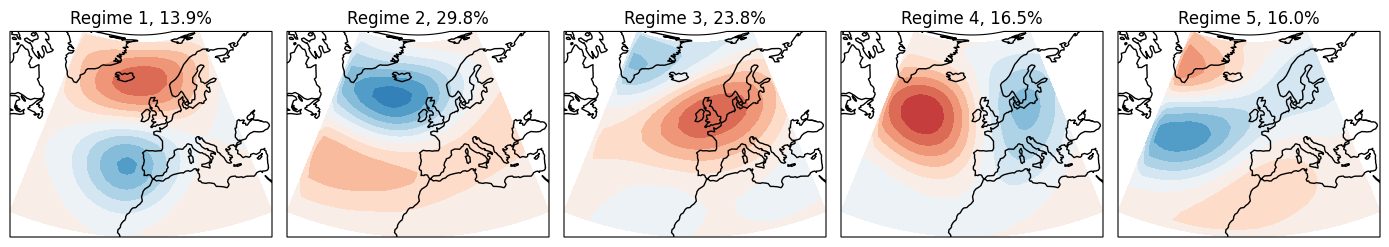

In [47]:
#bysouma changed the name of the fucntion

cluster_centers_vis = cf.visualise_contourplot(cluster_centers = means_preciporder, unit = '[m]', 
                                            regime_names = ['Regime 1', 'Regime 2', 'Regime 3',
                                                                         'Regime 4', 'Regime 5', 'Regime 6',
                                                                         'Regime 7', 'Regime 8', 'Regime 9', 'Regime 10'], 
                                             vmin=-4, vmax=4.5, steps=0.5, 
                                             color_scheme = 'RdBu_r', 
                                                      labels_data = X, labels=labels_reordered,
                                                      borders=False, 
                                                     col_number=cluster_number, projection = ccrs.AlbersEqualArea(central_longitude=-10, central_latitude=50))

plt.savefig(filepath+'cluster_centers_'+str(cluster_number)+'.png')

**Precipitation odds ratio**

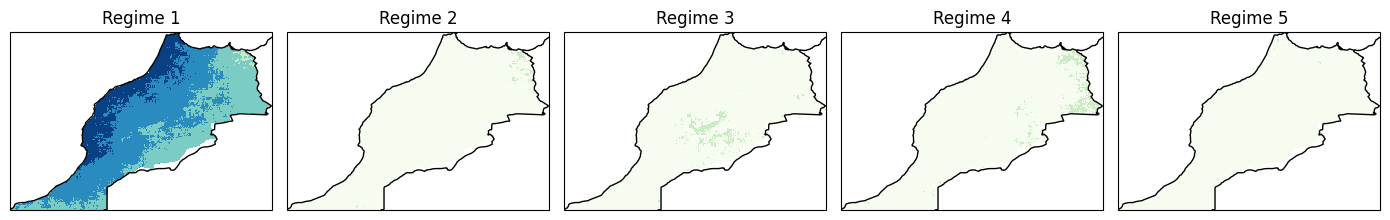

In [48]:
pr_qn95_ratio = cf.calculate_conditional_probability_change_label(threshold_matrix = threshold_qn95, 
                                                        labels=labels_reordered,
                                                       comparison = 'ratio', shift_value=0)
#changed bysouma
pr_qn95_vis = cf.visualise_spatial_oddsratio(dataset_xarray = pr_qn95_ratio, unit='', 
                                   color_scheme = 'GnBu', vmin = 0, vmax=5, steps=6, 
                                   title = 'Odds ratio of 95th percentile precipitation',
                                             regime_names = ['Regime 1', 'Regime 2', 'Regime 3',
                                                                         'Regime 4', 'Regime 5', 'Regime 6',
                                                                         'Regime 7', 'Regime 8', 'Regime 9', 'Regime 10'],
                                   borders=True, projection=ccrs.PlateCarree(central_longitude=0), 
                                               col_number=cluster_number)

plt.savefig(filepath+'precip_odds_ratio_'+str(cluster_number)+'_preciporder.png')


### Persistence & Silhouette

In [49]:
persistence = cf.calculate_regime_length(labels_reordered.astype(int)).groupby('Regime').mean()['Length'].reset_index()

print(persistence['Length'].mean())

# FIRST ROUND
#df = pd.DataFrame(data={'k': [str(cluster_number)]*cluster_number,
#                        'Method': ['CMM-VAE']*cluster_number,
#                        'Regime': persistence['Regime'].values, 
#                        'Persistence': persistence['Length'].values})
#df.to_csv(filepath+'persistence.csv', index=False)


# OTHER ROUND
#df_prior = pd.read_csv(filepath+'persistence.csv')
#df = pd.DataFrame(data={'k': [str(cluster_number)]*cluster_number, 
 #                       'Method': ['CMM-VAE']*cluster_number,
 #                       'Regime': persistence['Regime'].values, 
 #                       'Persistence': persistence['Length'].values})
#df_new = df_prior.append(df)
#df_new.to_csv(filepath+'persistence.csv', index=False)

sil_score = silhouette_score(cf.reshape_data_for_clustering(z500), final_labels)
print(sil_score)

# FIRST ROUND
df = pd.DataFrame(data={'k': [cluster_number], 'silhouette_score': [sil_score], 'method': ['CMM-VAE']})
df.to_csv(filepath+'silhouette_score.csv', index=False)

# OTHER ROUND
#df_prior = pd.read_csv(filepath+'silhouette_score.csv')
#df = pd.DataFrame(data={'k': [cluster_number], 'silhouette_score': [sil_score], 'method': ['CMM-VAE']})
#df_new = df_prior.append(df)
#df_new.to_csv(filepath+'silhouette_score.csv', index=False)

6.54868738521864
0.09571488113177473
